In [38]:
import sys
sys.path.insert(0, "../")
from pydmc import *
import scipy.special as spec

q0 = 0.8253525490491695
a0 = 1
nconf = 1
time_step = 1e-2
reference_energy = 3.67603
blocks = 10_000
steps_per_block = 10
# number of equilibration blocks
neq = 10
hamiltonian = lambda psi, x: -0.5*psi.laplacian(x)
da = 1e-3


def mathieu_modcem1(m, q, x):
    return spec.mathieu_modcem1(m, q, x)

def mathieu_cem(m, q, x):
    # Angular mathieu function in scipy takes input
    # in degrees
    return spec.mathieu_cem(m, q, x*180/np.pi)

def ground_state(mu, nu):
    return mathieu_modcem1(0, q0, mu)[0]*mathieu_cem(0, q0, nu)[0]

class GuidingWaveFunction(WaveFunction, GeometryParametrized):

    def __init__(self, a):
        self._a = a

    def __call__(self, x):
        x, y = x
        #alpha = self._a[0]*np.cosh(1)
        #beta = self._a[0]*np.sinh(1)
        #r = np.sqrt((x/alpha)**2 + (y/beta)**2)
        #return (r + 1)/2 * (1 - (r+1)/2)
        mu = np.real(np.arccosh((x + 1j*y)/self._a[0]))
        nu = np.imag(np.arccosh((x + 1j*y)/self._a[0]))
        return x*ground_state(mu, nu)

    def gradient(self, x):
        return gradient_fd(self, x)
    
    def laplacian(self, x):
        return laplacian_fd(self, x)

    def geometry_parameters(self):
        return self._a

    def deform(self, parameter_change):
        return GuidingWaveFunction(self._a + parameter_change)


def dmc(da, vcut=True):
    brancher = SRBrancher()
    ar = DiffuseAcceptReject(fixed_node=True)

    guiding_wf = GuidingWaveFunction(np.array([a0]))

    np.random.seed(0)
    confs = [np.random.uniform(low=-1, high=1, size=2) for _ in range(nconf)]
    walkers = [Walker(conf, 1.0) for conf in confs]

    fas = [
        ForcesDriftDifGfunc(np.array([da]), nconf, warp=False),
        ForcesDriftDifGfunc(np.array([da]), nconf, warp=True),
        ForcesVD(np.array([da]), nconf, warp=False),
        ForcesVD(np.array([da]), nconf, warp=True)
    ]

    if vcut:
        cutoff = velocity_cutoff_umrigar
    else:
        cutoff = lambda v, tau: v
    
    dmc = DMC(hamiltonian, walkers, brancher, ar, guiding_wf, reference_energy, 
              force_accumulators=fas, velocity_cutoff=cutoff)
    dmc.run_dmc(time_step, blocks, steps_per_block, neq=neq, progress=True)

    return dmc


def compute_forces(fa):
    errs = []
    bs = list(range(2, blocks-neq+1, (blocks-neq+1)//20))
    for b in bs:
        nconf = b * steps_per_block
        flhf, flpulay, fhf, fpulay, w = fa.compute_forces(steps_per_block, nconf)
        f = fhf + fpulay
        fl = flhf + flpulay
        f_err = block_error(fl[0, :], block_size=steps_per_block)
        errs.append(f_err)

    return flhf, flpulay, w

In [39]:
res_cut = dmc(da)
res_nocut = dmc(da, vcut=False)

100%|██████████| 10000/10000 [15:01<00:00, 11.09it/s]


## Exact

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


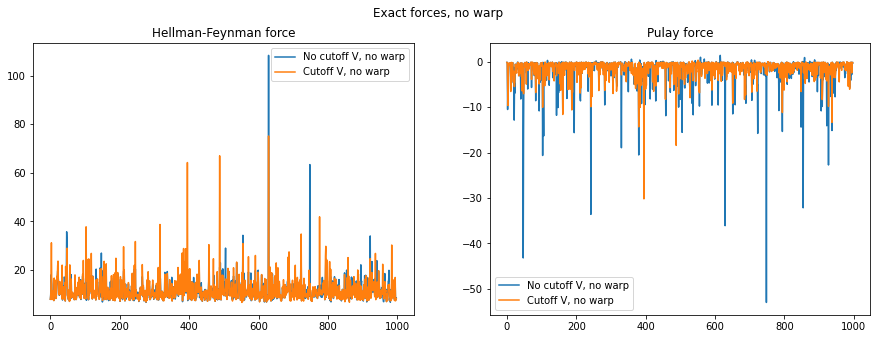

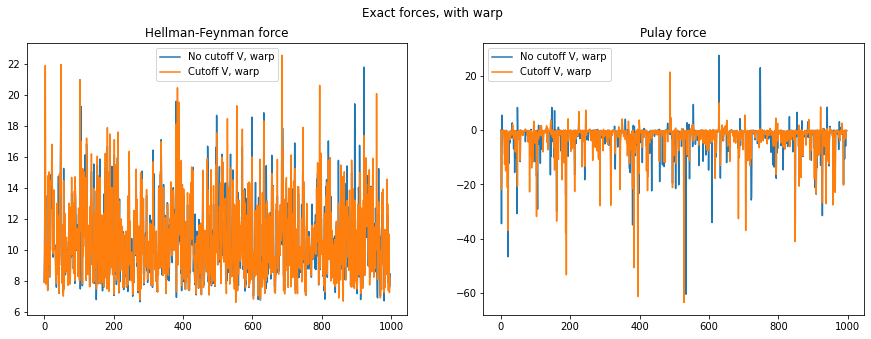

In [46]:
bs = 100

flhf_cut, flpulay_cut, w = compute_forces(res_cut.force_accumulators[0])
flhf_cut_warp, flpulay_cut_warp, w_cut_warp = compute_forces(res_cut.force_accumulators[1])

flhf_nocut, flpulay_nocut, w_nocut = compute_forces(res_nocut.force_accumulators[0])
flhf_nocut_warp, flpulay_nocut_warp, w_nocut_warp = compute_forces(res_nocut.force_accumulators[1])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=False)
fig.suptitle("Exact forces, no warp")
axes[0].plot(bin_samples(flhf_nocut[0, :], bs), label="No cutoff V, no warp")
axes[0].plot(bin_samples(flhf_cut[0, :], bs), label="Cutoff V, no warp")
axes[1].plot(bin_samples(flpulay_nocut[0, :], bs), label="No cutoff V, no warp")
axes[1].plot(bin_samples(flpulay_cut[0, :], bs), label="Cutoff V, no warp")
axes[0].set_title("Hellman-Feynman force"); axes[1].set_title("Pulay force")

axes[0].legend();axes[1].legend()
fig.savefig("exact_nowarp.eps")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=False)
fig.suptitle("Exact forces, with warp")
axes[0].plot(bin_samples(flhf_nocut_warp[0, :], bs), label="No cutoff V, warp")
axes[0].plot(bin_samples(flhf_cut_warp[0, :], bs), label="Cutoff V, warp")
axes[1].plot(bin_samples(flpulay_nocut_warp[0, :], bs), label="No cutoff V, warp")
axes[1].plot(bin_samples(flpulay_cut_warp[0, :], bs), label="Cutoff V, warp")
axes[0].set_title("Hellman-Feynman force"); axes[1].set_title("Pulay force")

axes[0].legend();axes[1].legend()
fig.savefig("exact_warp.eps")

plt.show()

## VD

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


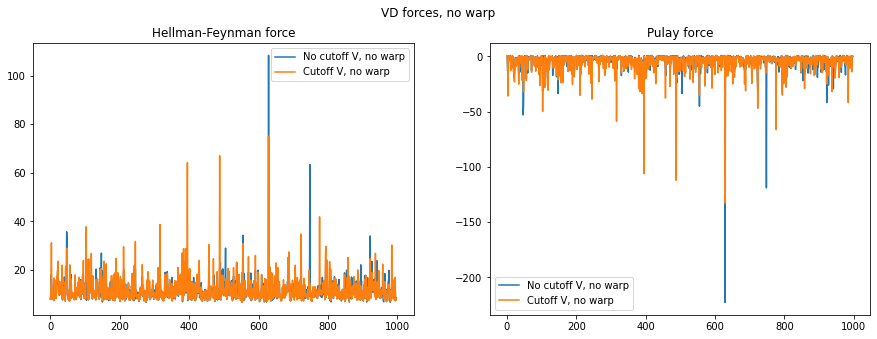

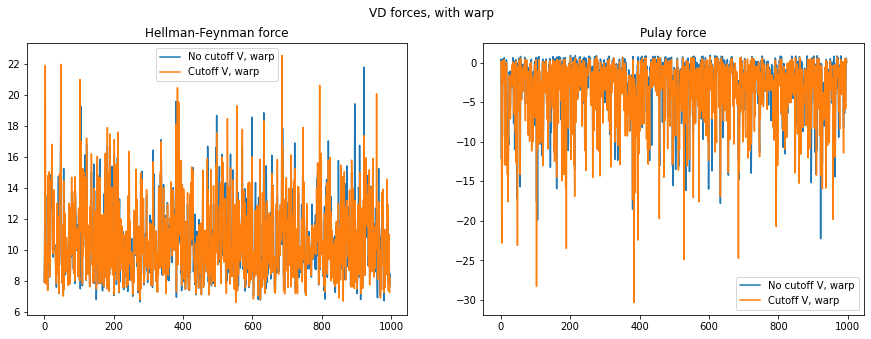

In [47]:
bs = 100

flhf_cut, flpulay_cut, w = compute_forces(res_cut.force_accumulators[2])
flhf_cut_warp, flpulay_cut_warp, w_cut_warp = compute_forces(res_cut.force_accumulators[3])

flhf_nocut, flpulay_nocut, w_nocut = compute_forces(res_nocut.force_accumulators[2])
flhf_nocut_warp, flpulay_nocut_warp, w_nocut_warp = compute_forces(res_nocut.force_accumulators[3])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=False)
fig.suptitle("VD forces, no warp")
axes[0].plot(bin_samples(flhf_nocut[0, :], bs), label="No cutoff V, no warp")
axes[0].plot(bin_samples(flhf_cut[0, :], bs), label="Cutoff V, no warp")
axes[1].plot(bin_samples(flpulay_nocut[0, :], bs), label="No cutoff V, no warp")
axes[1].plot(bin_samples(flpulay_cut[0, :], bs), label="Cutoff V, no warp")
axes[0].set_title("Hellman-Feynman force"); axes[1].set_title("Pulay force")

axes[0].legend();axes[1].legend()
fig.savefig("VD_nowarp.eps")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=False)
fig.suptitle("VD forces, with warp")
axes[0].plot(bin_samples(flhf_nocut_warp[0, :], bs), label="No cutoff V, warp")
axes[0].plot(bin_samples(flhf_cut_warp[0, :], bs), label="Cutoff V, warp")
axes[1].plot(bin_samples(flpulay_nocut_warp[0, :], bs), label="No cutoff V, warp")
axes[1].plot(bin_samples(flpulay_cut_warp[0, :], bs), label="Cutoff V, warp")
axes[0].set_title("Hellman-Feynman force"); axes[1].set_title("Pulay force")

axes[0].legend();axes[1].legend()
fig.savefig("VD_warp.eps")

plt.show()

## HF force comparison

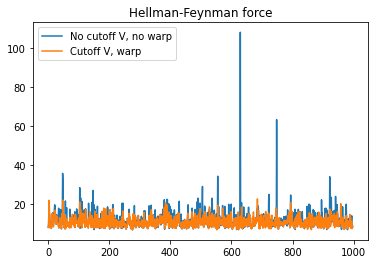

In [48]:
bs = 100

flhf_cut_warp, flpulay_cut_warp, w_cut_warp = compute_forces(res_cut.force_accumulators[1])
flhf_nocut, flpulay_nocut, w_nocut = compute_forces(res_nocut.force_accumulators[0])

plt.figure()
plt.plot(bin_samples(flhf_nocut[0, :], bs), label="No cutoff V, no warp")
plt.plot(bin_samples(flhf_cut_warp[0, :], bs), label="Cutoff V, warp")
plt.title("Hellman-Feynman force")
plt.savefig("HF_cutoff_warp.eps")
plt.legend()